In [1]:
import bh_spc
from bh_spc import spcm

import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with bh_spc.ini_file(
    bh_spc.minimal_spcm_ini(spcm.DLLOperationMode.SIMULATE_SPC_130EM)
) as ini:
    spcm.init(ini)

In [4]:
mod_no = 0

In [5]:
spcm.get_init_status(mod_no)

<InitStatus.OK: 0>

In [6]:
spcm.set_parameter(mod_no, spcm.ParID.MODE, 1)

In [7]:
params = spcm.get_parameters(mod_no)

for par, val in params.items():
    print(f"{par} = {val}")

cfd_limit_low = -0.0
cfd_limit_high = 80.0
cfd_zc_level = 0.0
cfd_holdoff = 5.0
sync_zc_level = 0.0
sync_freq_div = 4
sync_holdoff = 4.0
sync_threshold = -19.60784339904785
tac_range = 50.033573150634766
tac_gain = 1
tac_offset = 0.0
tac_limit_low = 10.196078300476074
tac_limit_high = 80.0
adc_resolution = 12
ext_latch_delay = 0
collect_time = 0.009999999776482582
display_time = 1.0
repeat_time = 10.0
stop_on_time = 1
stop_on_ovfl = 1
dither_range = 0
count_incr = 1
mem_bank = 0
dead_time_comp = 0
scan_control = 0
routing_mode = 0
tac_enable_hold = 0.0
mode = 1
scan_size_x = 1
scan_size_y = 1
scan_rout_x = 1
scan_rout_y = 1
scan_polarity = 0
scan_flyback = 65537
scan_borders = 0
pixel_time = 2.0000000233721948e-07
pixel_clock = 0
line_compression = 1
trigger = 0
ext_pixclk_div = 1
rate_count_time = 1.0
macro_time_clk = 0
add_select = 0
adc_zoom = 0
xy_gain = 1
img_size_x = 1
img_size_y = 1
img_rout_x = 1
img_rout_y = 1
master_clock = 2
adc_sample_delay = 0
detector_type = 1
tdc_control

In [8]:
# For this demonstration, we will turn off `stop_on_time`, mostly because it
# does not appear to work in simulation mode. By turning it off, running this
# example on real hardware should behave the same way.
params.stop_on_time = 0

# (Set other parameters here!)

spcm.set_parameters(mod_no, params)

In [9]:
duration = 0.1  # s
buf_size = 32768  # Max number of 16-bit words in a single read.

spcm.start_measurement(mod_no)
start_time = time.monotonic()

data = []  # Collect arrays of data into a list.
while True:
    elapsed = time.monotonic() - start_time
    if elapsed >= duration:
        spcm.stop_measurement(mod_no)
        break
    buf = spcm.read_fifo_to_array(mod_no, buf_size)
    if len(buf):
        data.append(buf)
    if len(buf) < buf_size:  # We've read all there is to read.
        time.sleep(0.001)

# Make sure to read the data that arrived after stopping (if you need it).
while True:
    buf = spcm.read_fifo_to_array(mod_no, buf_size)
    if not len(buf):
        break
    data.append(buf)

In [10]:
records = np.concatenate(data).view(np.uint32)
len(records)

458787

In [11]:
had_gap = np.any(np.bitwise_and(records, 1 << 29))
print("There was {} gap".format("a" if had_gap else "no"))

There was no gap


In [17]:
photons = np.extract(np.bitwise_and(records, 0b1001 << 28) == 0, records)
len(photons)
np.right_shift(photons, 16)

array([ 454, 1662, 1921, ..., 2391, 2038, 1505], dtype=uint32)

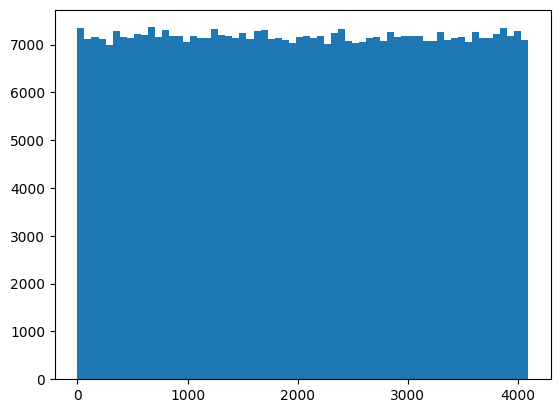

In [13]:
max_12bit = (1 << 12) - 1  # 4095
microtimes = np.bitwise_and(np.right_shift(photons, 16), max_12bit)

# Reverse the microtimes by subtracting from the max value, because the raw
# microtime is measured from photon to SYNC, not SYNC to photon.
microtimes = max_12bit - microtimes

h = plt.hist(microtimes, bins=64)